# Прогнозирование электропотребления Калинградской области

## Задача
Разработка сервиса прогнозирования почасового энергопотребления региона на сутки, в МВт*ч.
## Цель
Разработать надежную и точную модель прогнозирования объема почасового энергопотребления на следующие сутки для Калининградской области с использованием доступных исторических данных и соответствующих переменных для эффективного распределения ресурсов.
## Описание задачи
Разработать предиктивную модель, которая позволит прогнозировать почасовое энергопотребление региона на следующие сутки на основе имеющихся данных о потреблении электроэнергии в прошлом и соответствующих факторах, влияющих на потребление энергии.
## Вывод

**Модель LGBM regressor с {n_estimators': 2700} является оптимальным решением для прогнозирования почасового потребления энергии в Калининградской области.**  

**Модель демонстрирует значительное улучшение по сравнению с базовым методом прогнозирования значениями прошлого дня *MAE: 15.008*, что подтверждается следующими метриками:**

| Метрика | Обучающая выборка | Тестовая выборка |
|---------|-------------------|------------------|
| MAE     | 6.897             | 5.657            |
| MAPE    | 0.0135            | 0.0132           |
| R2      | 0.982             | 0.988            |


## Датасет
*  date – дата
*  time – время, время представлено в диапазоне 0 – 23, что означает 24 часа в сутках
*  target – фактическое потребление на указанную дату
* temp – фактическая температура на указанную дату
* temp_pred – прогноз температуры на указанную дату
* weather_fact – фактическая погода на указанную дату
* weather_pred – прогноз погоды на указанную дату

## Метрики

1) MAE (Главная метрика)  
2) MAPE (Вспомогательная метрика)  
3) R2-score (Вспомогательная метрика)

## Краткое описание проекта:
1. Импорт и загрузка данных:
* Импорт необходимых библиотек
* Определяется парсер дат, а затем загружаются обучающий и тестовый наборы данных, при этом столбцы даты и времени разбираются, а дата и время устанавливаются в качестве индекса.  
* Загрузка данных.
2. Исследовательский анализ данных:  
* Определяется функция check_data для анализа набора данных, предоставляя информацию о типах данных, уникальных значениях, описательной статистике, а также проверяя наличие дубликатов и монотонность временного ряда.  
* Гистограммы и графики временных рядов со скользящими средними и стандартными отклонениями визуализируют распределение и сезонность потребления энергии.  
* Сезонная декомпозиция для дальнейшего понимания тренда, сезонности и остаточных компонентов временного ряда на дневном, недельном, месячном и годовом масштабах.  
* Тест Дики-Фуллера (ADF) используется для проверки стационарности, подтверждая, что временной ряд является стационарным.  
* Графики автокорреляции показывают дневные и годовые закономерности сезонности в потреблении электроэнергии.  
3. Базовая модель:  
* Создается простая базовая модель, использующая медиану обучающих данных, чтобы сравнить ее производительность с более сложными моделями.
* Исследуется использование потребления электроэнергии за предыдущий день в качестве предиктора, предоставляя точку отсчета для улучшения.  
4. Создание признаков:  
* Функция find_weather извлекает такие признаки, как ветер, облачность и осадки, из текстовых описаний погоды.  
* Функция make_features генерирует различные признаки, включая:
    - Признаки с лагами для целевой переменной, температуры и переменных погоды.  
    - Признаки на основе времени, такие как месяц, день, день недели, час и индикаторы праздников.  
    - Циклическое кодирование признаков времени с использованием преобразований синуса и косинуса.  
    - Признаки сезонности, указывающие на ночь, день, вечер и сочетания сезонов с будними днями/выходными.  
    - Скользящие средние для целевой переменной и признаков температуры.
* Суточные агрегированные признаки и создает модель суточного прогноза с использованием регрессии ElasticNet, которая затем используется в качестве дополнительного признака для почасовой модели.
5. Обучение и оценка модели:
* Регрессор LightGBM для финальной почасовой модели прогнозирования.
Для надежной оценки используется кросс-валидация TimeSeriesSplit.
* Считаем MAE, MAPE и R2 для оценки производительности модели.
* Важность признаков визуализируется, чтобы понять вклад различных признаков.
* Прогнозы модели сравниваются с фактическими значениями для визуального анализа.
6. Тестирование и выводы:
* Обученная модель используется для прогнозирования потребления энергии на тестовом наборе данных, а производительность оценивается с помощью значений MAE, MAPE и R2.
* Достигнутые значения указывают на хорошую производительность и подчеркивают эффективность выбранной модели и подхода к созданию признаков.

## Импорт

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import lightgbm as lgb
import warnings
import re

from lightgbm import LGBMRegressor
from tqdm.notebook import tqdm
from datetime import datetime, date
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error, r2_score

import joblib

RS = 45
pd.options.display.max_columns = None

### Загрузка данных

In [ ]:
# создадим парсер дат
date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H')

# загрузим данные из папки, назначим даты индексами
try:
    # Попробуйте загрузить данные из текущей директории
    train = pd.read_csv('train_dataset.csv',
                     index_col=[0],
                     parse_dates={'datetime': ['date', 'time']},
                     date_parser=date_parser
                    )
    test = pd.read_csv('test_dataset.csv',
                     index_col=[0],
                     parse_dates={'datetime': ['date', 'time']},
                     date_parser=date_parser
                    )
except FileNotFoundError:
    try:
        # Если файлы не найдены в текущей директории, загрузите из директории /content/drive/MyDrive/Colab Notebooks
        train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_dataset.csv',
                         index_col=[0],
                         parse_dates={'datetime': ['date', 'time']},
                         date_parser=date_parser
                        )
        test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_dataset.csv',
                         index_col=[0],
                         parse_dates={'datetime': ['date', 'time']},
                         date_parser=date_parser
                        )
    except FileNotFoundError:
        train = pd.read_csv('train_dataset.csv',
                     index_col=[0],
                     parse_dates={'datetime': ['date', 'time']},
                     date_parser=date_parser
                    )
        test = pd.read_csv('test_dataset.csv',
                     index_col=[0],
                     parse_dates={'datetime': ['date', 'time']},
                     date_parser=date_parser
                    )


## Исследовательский анализ данных

In [ ]:
# напишем функцию для проверки датасета
def check_data(df):
    display(
        df.info(),
        df.nunique(),
        df.describe(include='all'),
        df.head(),
        df.sample(5, random_state=RS)
    )
    print('Дубликатов строк:', df.duplicated().sum())

    # проверим монотонность временного ряда
    print('Временная последовательность соблюдена:', df.index.is_monotonic_increasing)

    # проверим временной ряд на повторы
    print('Повторов нет:', df.index.is_unique)

In [ ]:
check_data(train)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        37224 non-null  float64
 1   temp          37224 non-null  float64
 2   temp_pred     37136 non-null  float64
 3   weather_pred  37136 non-null  object 
 4   weather_fact  37223 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.7+ MB


target          35327
temp              474
temp_pred          54
weather_pred     2181
weather_fact      580
dtype: int64

,target,temp,temp_pred,weather_pred,weather_fact
count,37224.000000,37224.000000,37136.000000,37136,37223
unique,NaN,NaN,NaN,2181,580
top,NaN,NaN,NaN,ясно,ясно
freq,NaN,NaN,NaN,3786,6264
mean,483.731441,8.748995,8.768984,NaN,NaN
std,101.459375,8.125722,8.017520,NaN,NaN
min,198.982000,-21.700000,-20.000000,NaN,NaN
25%,418.950750,2.600000,3.000000,NaN,NaN
50%,473.064000,7.900000,8.000000,NaN,NaN
75%,561.217000,14.700000,15.000000,NaN,NaN


,target,temp,temp_pred,weather_pred,weather_fact
datetime,,,,,
2019-01-01 00:00:00,481.510,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


,target,temp,temp_pred,weather_pred,weather_fact
datetime,,,,,
2019-08-05 14:00:00,456.279,23.2,20.0,п/обл,облачно
2021-10-20 22:00:00,529.379,16.3,15.0,пер.обл.,"обл., дождь"
2021-02-05 19:00:00,697.944,-3.5,-6.0,обл с пр,снег
2020-02-26 22:00:00,571.845,3.4,3.0,"обл, 24% дождь",п/обл
2022-12-25 17:00:00,652.458,-0.1,3.0,пасмурно,пасмурно


Дубликатов строк: 1
Временная последовательность соблюдена: True
Повторов нет: True


In [ ]:
check_data(test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 00:00:00 to 2023-07-31 23:00:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        2928 non-null   float64
 1   temp          2928 non-null   float64
 2   temp_pred     2904 non-null   float64
 3   weather_pred  2904 non-null   object 
 4   weather_fact  2928 non-null   object 
dtypes: float64(3), object(2)
memory usage: 137.2+ KB


None

target          2905
temp             270
temp_pred         32
weather_pred     246
weather_fact     121
dtype: int64

,target,temp,temp_pred,weather_pred,weather_fact
count,2928.000000,2928.000000,2904.000000,2904,2928
unique,NaN,NaN,NaN,246,121
top,NaN,NaN,NaN,ясно,ясно
freq,NaN,NaN,NaN,666,396
mean,419.467047,13.768613,13.910124,NaN,NaN
std,71.393070,6.479879,6.381692,NaN,NaN
min,264.819000,-3.100000,-3.000000,NaN,NaN
25%,371.384250,9.200000,9.000000,NaN,NaN
50%,431.477500,14.000000,15.000000,NaN,NaN
75%,462.414250,18.700000,19.000000,NaN,NaN


,target,temp,temp_pred,weather_pred,weather_fact
datetime,,,,,
2023-04-01 00:00:00,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"


,target,temp,temp_pred,weather_pred,weather_fact
datetime,,,,,
2023-05-27 23:00:00,408.730,6.7,8.0,ясно,дымка
2023-05-28 19:00:00,410.807,10.6,13.0,ясно,малообл.
2023-05-26 21:00:00,421.780,5.8,8.0,ясно,"дымка, ветер"
2023-05-10 15:00:00,462.125,18.8,17.0,"ясно, ветер",ясно
2023-05-23 23:00:00,409.097,17.0,12.0,ясно,пер.обл.


Дубликатов строк: 0
Временная последовательность соблюдена: True
Повторов нет: True


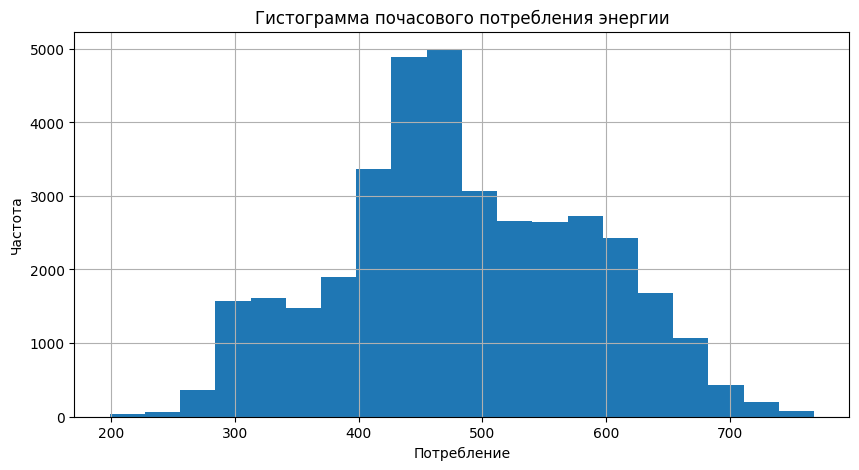

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
train.target.hist(bins=20)
plt.title('Гистограмма почасового потребления энергии')
plt.xlabel('Потребление')
plt.ylabel('Частота')
plt.show()

Существует четко выраженный пик потребления энергии около 450, который встречается наиболее часто.

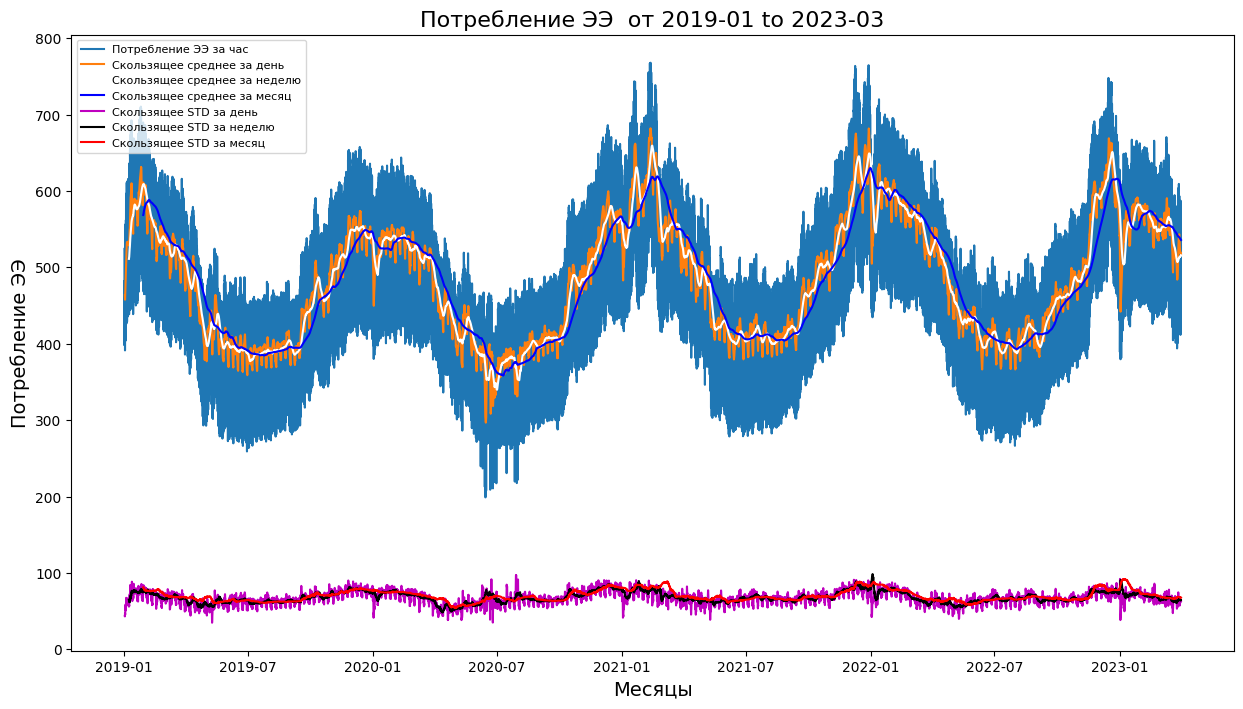

In [ ]:
# зададим размер графика
plt.figure(figsize = (15,8))

# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(train['target'], label = 'Потребление ЭЭ за час')
plt.plot(train['target'].rolling(24).mean(), label = 'Скользящее среднее за день')
plt.plot(train['target'].rolling(168).mean(), label = 'Скользящее среднее за неделю', color='white')
plt.plot(train['target'].rolling(672).mean(), label = 'Скользящее среднее за месяц', color='b')
plt.plot(train['target'].rolling(24).std(), label = 'Скользящее STD за день', color='m')
plt.plot(train['target'].rolling(168).std(), label = 'Скользящее STD за неделю', color='black')
plt.plot(train['target'].rolling(672).std(), label = 'Скользящее STD за месяц', color='red')
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 8)

# добавим подписи к осям и заголовки
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Потребление ЭЭ', fontsize = 14)
plt.title('Потребление ЭЭ  от 2019-01 to 2023-03', fontsize = 16)

# выведем обе кривые на одном графике
plt.show()

Четко видны пики потребления в зимние месяцы, связанные с более высокими энергозатратами на отопление.
Более низкое потребление в летние месяцы, когда энергозатраты на охлаждение ниже.  

Существует высокая вариативность потребления в течение суток, что отражается в большой амплитуде колебаний почасовых значений.
Нерегулярные всплески потребления, вероятно, связаны с погодными, производственными или иными факторами.

In [ ]:
def resampled_data(ds):
    '''
    функция, которая подготавливает исходный датасет:
    заполняет пропуски
    делает признак фактической температуры с лагом в 24 часа
    '''
    # заполним пропуски
    ds2 = ds.ffill()

    # делаем суточный лаг для температуры
    ds2['temp_lag_24'] = ds2['temp'].shift(24)

    # удаляем столбец с фактической температурой
    ds2 = ds2.drop(columns=['temp'], axis=1) # , 'weather_fact'

    # устраняем пропуски, вместо нулей поставим NaN
    ds2.loc[ds2['weather_pred'] == '0', ['temp_pred', 'weather_pred']] = np.NaN

    # заполним пропуски в предсказаниях температуры, вчерашними показаниями фактическими температуры
    ds2.loc[ds2['temp_pred'].isna(), 'temp_pred'] =  ds2.loc[ds2['temp_pred'].isna(),'temp_lag_24']

    # тоже самое для погоды
    ds2.loc[ds2['weather_pred'].isna(), 'weather_pred'] =  ds2['weather_fact'].shift(24)

    # заполним пропуски в лагах, предсказанием температуры
    ds2.loc[ds2['temp_lag_24'].isna(), 'temp_lag_24'] = ds2.loc[:,'temp_pred']

    return ds2

In [ ]:
# преобразуем наш датасет
train_resampled = resampled_data(train)
train_resampled.head(5)

,target,temp_pred,weather_pred,weather_fact,temp_lag_24
datetime,,,,,
2019-01-01 00:00:00,481.510,2.0,"пасм, ветер",ветер,2.0
2019-01-01 01:00:00,462.872,2.0,"пасм, ветер",ветер,2.0
2019-01-01 02:00:00,449.718,2.0,"пасм, ветер",ветер,2.0
2019-01-01 03:00:00,430.908,2.0,"пасм, ветер","ветер, пасм",2.0
2019-01-01 04:00:00,415.163,2.0,"пасм, ветер","ветер, пасм",2.0


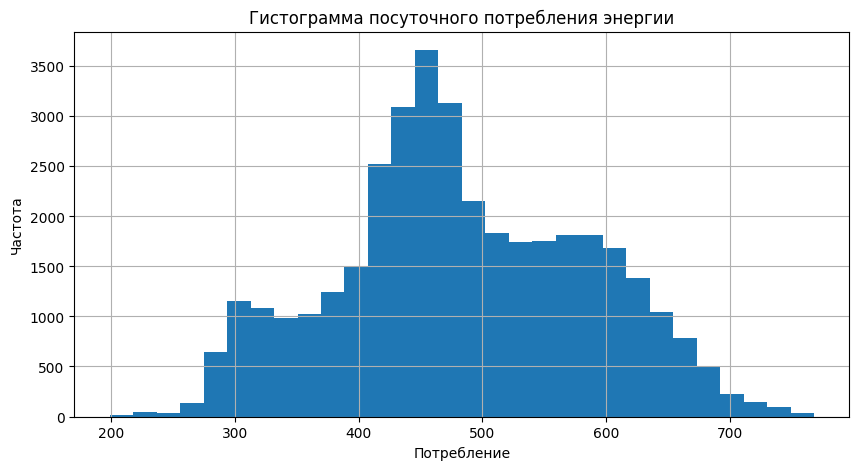

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
train_resampled.loc[:].target.hist(bins=30)
plt.title('Гистограмма посуточного потребления энергии')
plt.xlabel('Потребление')
plt.ylabel('Частота')
plt.show()

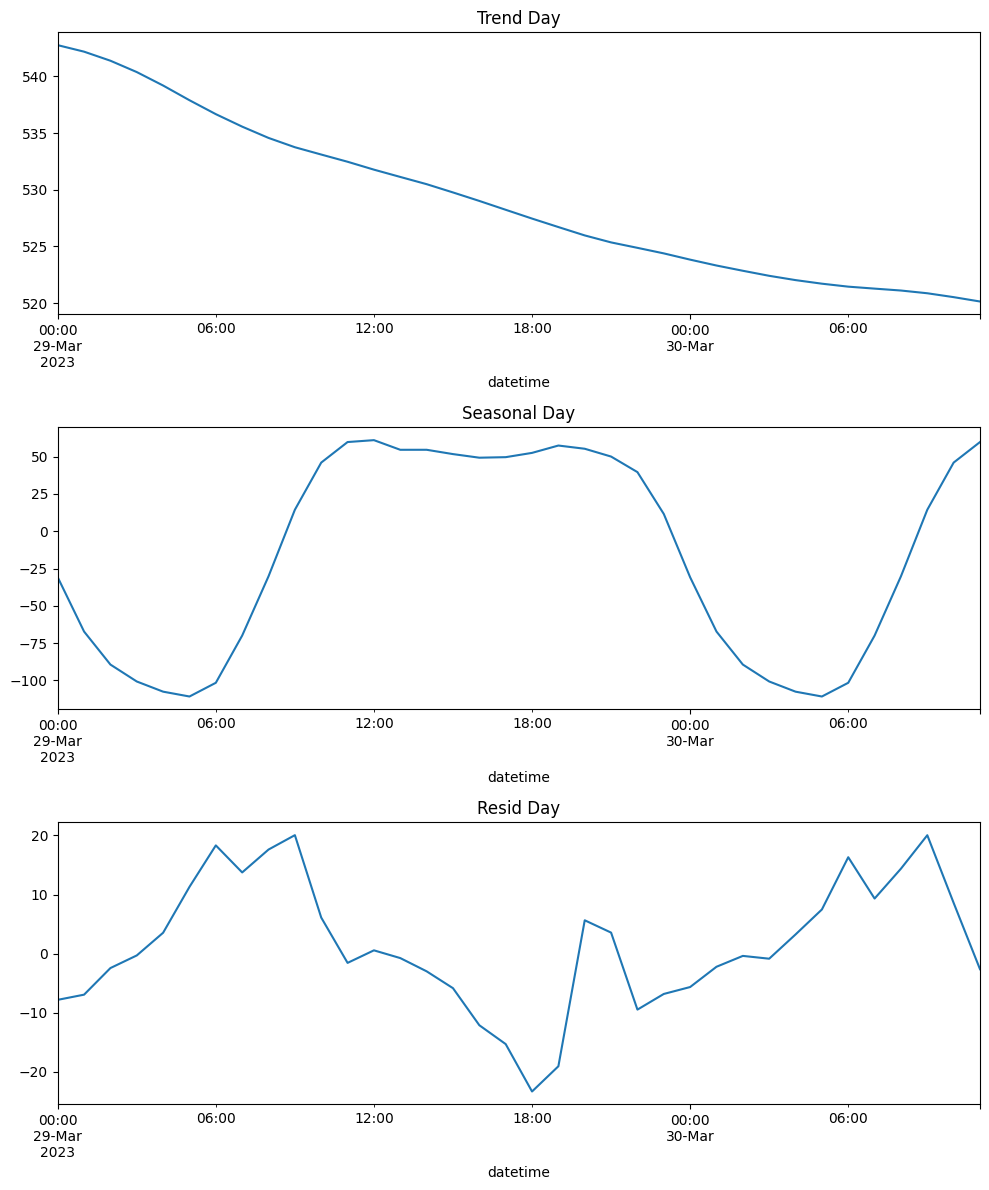

In [ ]:
# декомпозиция за день
decomposed = seasonal_decompose(train_resampled['target'])
period = 36

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend[-period*2:-period].plot(ax=plt.gca())
plt.title('Trend Day')
plt.subplot(312)
decomposed.seasonal[-period*2:-period].plot(ax=plt.gca())
plt.title('Seasonal Day')
plt.subplot(313)
decomposed.resid[-period*2:-period].plot(ax=plt.gca())
plt.title('Resid Day')
plt.tight_layout()

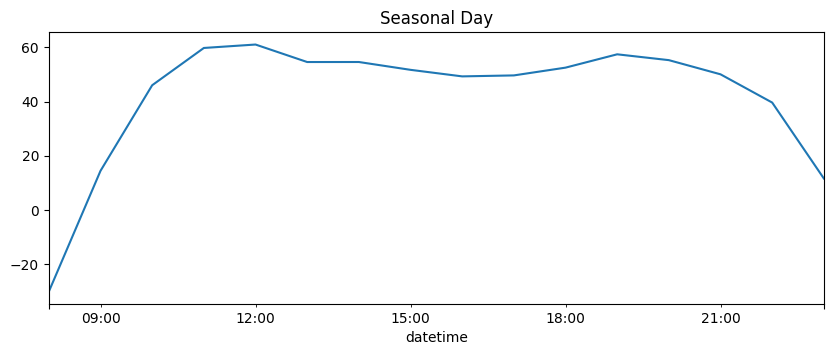

In [ ]:
# декомпозиция за день -  сезонность днем
decomposed = seasonal_decompose(train_resampled['target'])

plt.figure(figsize=(10, 12))

plt.subplot(312)
decomposed.seasonal[-16:].plot(ax=plt.gca())
plt.title('Seasonal Day');

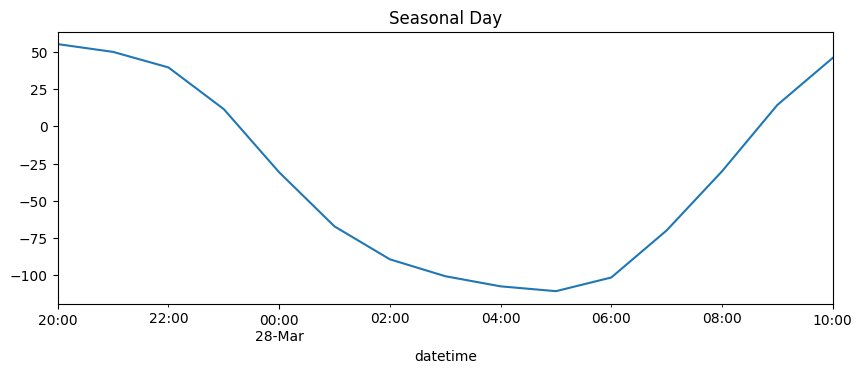

In [ ]:
# декомпозиция за день - сезонность ночью
decomposed = seasonal_decompose(train_resampled['target'])

plt.figure(figsize=(10, 12))

plt.subplot(312)
decomposed.seasonal[-100:-85].plot(ax=plt.gca())
plt.title('Seasonal Day');

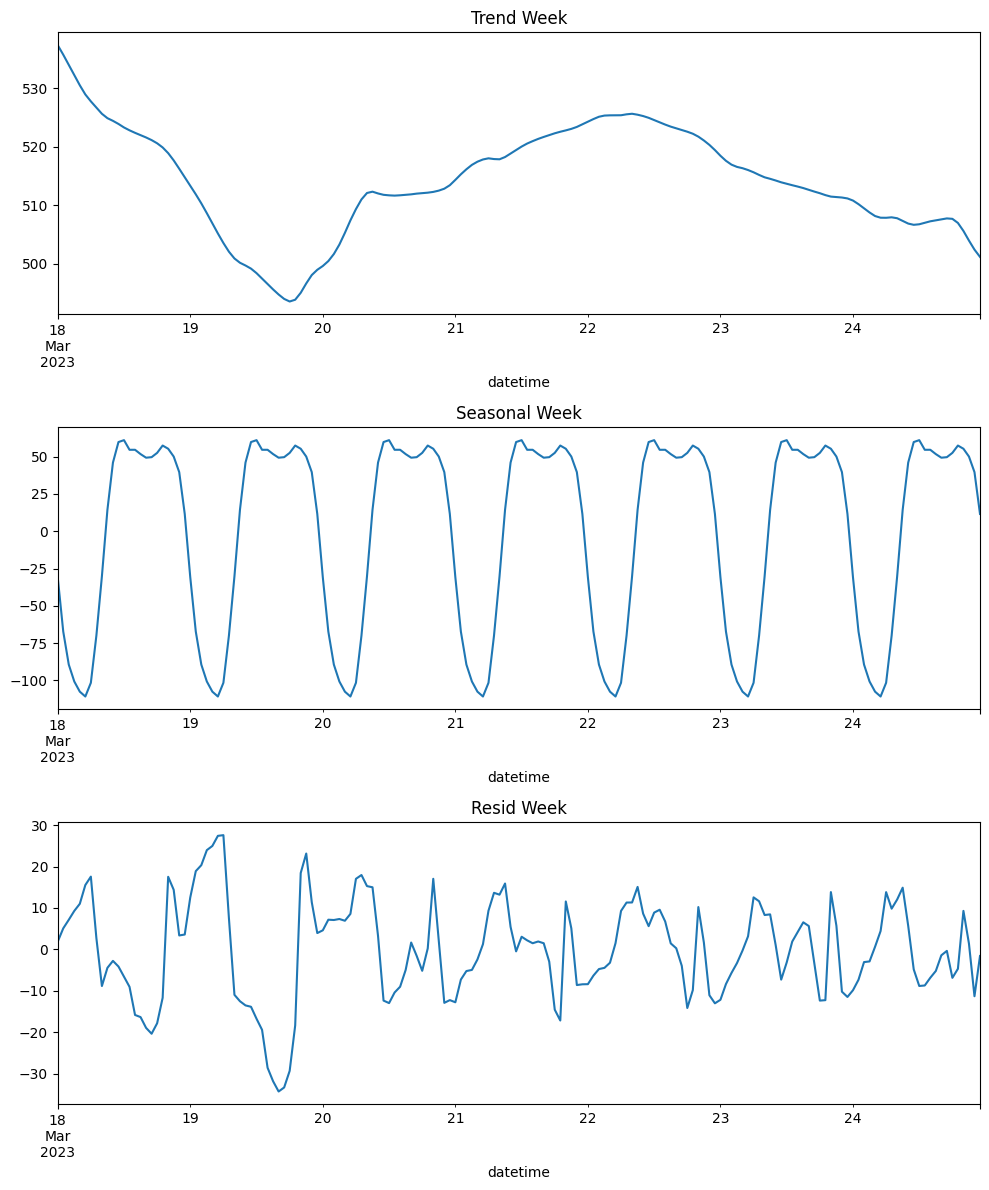

In [ ]:
# декомпозиция за неделю
decomposed = seasonal_decompose(train_resampled['target'])
period = 24 * 7

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend[-period*2:-period].plot(ax=plt.gca())
plt.title('Trend Week')
plt.subplot(312)
decomposed.seasonal[-period*2:-period].plot(ax=plt.gca())
plt.title('Seasonal Week')
plt.subplot(313)
decomposed.resid[-period*2:-period].plot(ax=plt.gca())
plt.title('Resid Week')
plt.tight_layout()

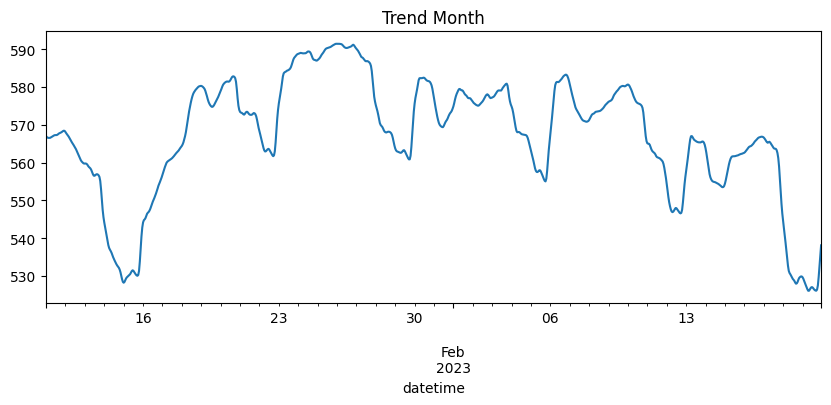

In [ ]:
# декомпозиция за месяц
decomposed = seasonal_decompose(train_resampled['target'])
period = 24*40

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend[-period*2:-period].plot(ax=plt.gca())
plt.title('Trend Month');

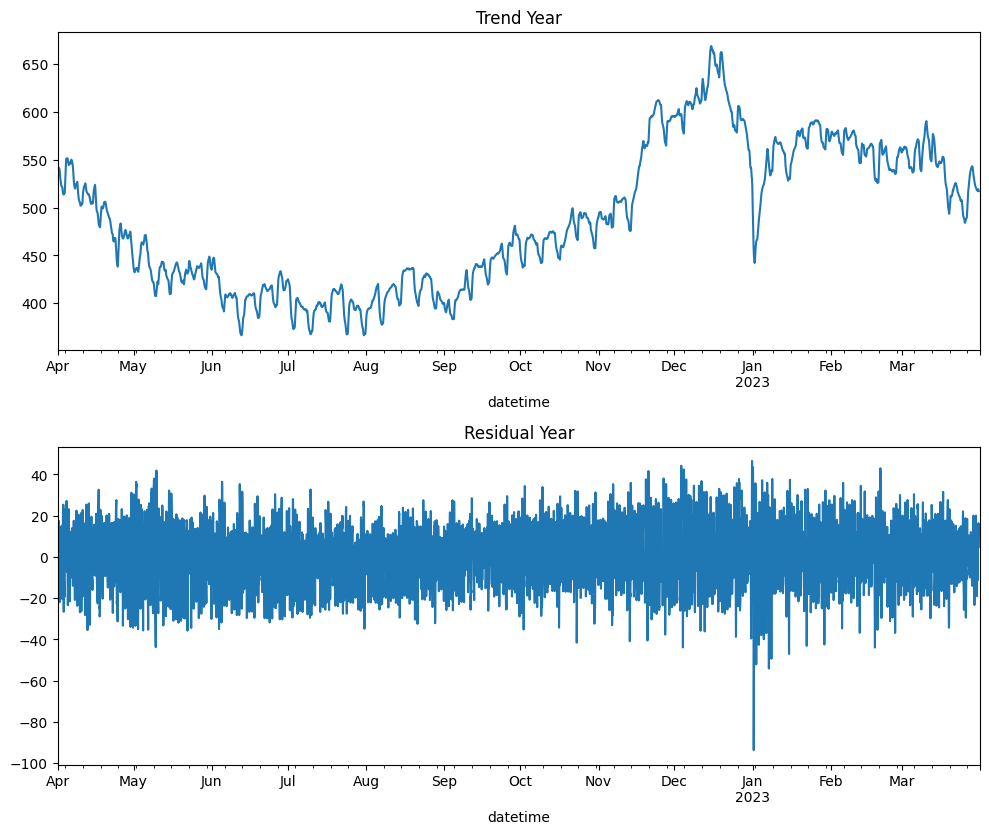

In [ ]:
# декомпозиция за год
plt.figure(figsize=(10, 12))

period = 24 * 365

plt.subplot(311)
decomposed.trend[-period :].plot(ax=plt.gca())
plt.title('Trend Year')
plt.subplot(312)
decomposed.resid[-period :].plot(ax=plt.gca())
plt.title('Residual Year')
plt.tight_layout()

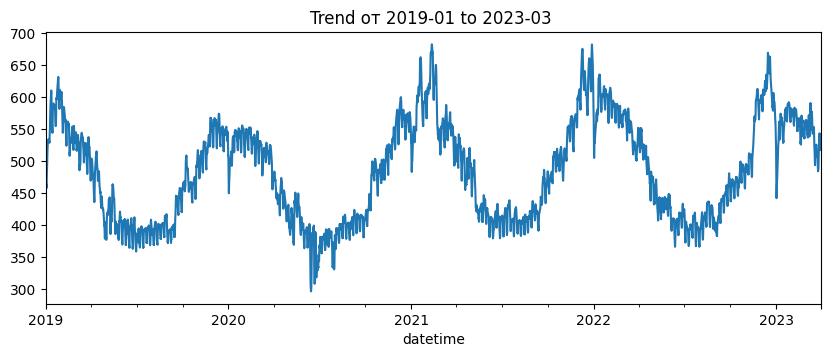

In [ ]:
# тренд за все время
plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend от 2019-01 to 2023-03 ');

In [ ]:
# Проверим данные на стационарность.
# Нулевая гипотеза — процесс нестационарный.
# Альтернативная гипотеза — процесс стационарный.
# Пороговое значение — 0,05.
adf_test = adfuller(train_resampled['target'])

# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.00026407064631531185


Pvalue меньше 5%.  
Отвергаем нулевую гипотезу.  
Временной ряд стационарен.

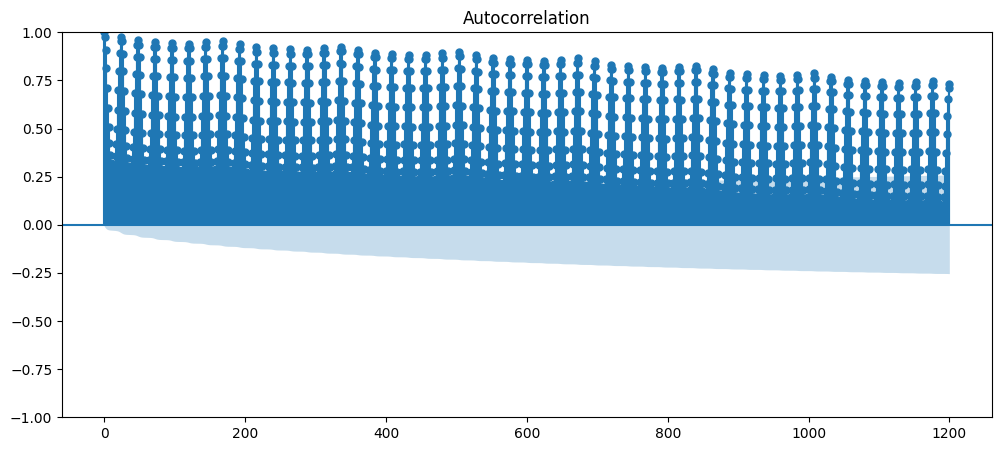

In [ ]:
fig = plt.figure(figsize=(12, 5))

plot_acf(train_resampled.iloc[:,:1], ax=plt.gca(), lags = 24*50)

plt.show()

Отчетливо видна дневная сезонность – высокая активность с 10 утра до 10 вечера. В течение дня есть два пика активности – в 11-12 часов и в 19 часов. Ночью потребление плавно снижается. Абсолютный минимум потребления приходится на 5 утра.

В выходные и праздничные дни потребление электроэнергии падает, что вполне закономерно. В течение года максимум потребления приходится на конец года из-за праздников и отопительного сезона. Летом потребление электроэнергии наименьшее. Новый год – особенное время, когда наблюдаются сильные выбросы. Временной ряд можно считать стационарным.


## Базовая модель

In [ ]:
# делаем базовую модель для сравнения своих решений
dummy_train, dummy_valid  = train_test_split(train_resampled, shuffle=False, test_size=24*62)
print(dummy_train.shape, dummy_valid.shape)

(35736, 5) (1488, 5)


In [ ]:
# сначала посмотрим примерный МАЕ для тренировочного датасета на валидации
test_resampled = resampled_data(test)

print("Средний объём электропотребления в час валидационная выборка:", dummy_valid['target'].mean())

pred_median = pd.Series(data=dummy_train['target'].median(), index=dummy_valid['target'].index)

print()
print("Предсказание медианой валидационная выборка:")
print("MAE:", mean_absolute_error(pred_median, dummy_valid['target']))

pred_previous = dummy_valid['target'].shift(24)
pred_previous.iloc[:24] = dummy_train.iloc[-24:, 0]

print()
print("Предсказание прошлым валидационная выборка:")
print("MAE:", mean_absolute_error(pred_previous, dummy_valid['target']))

Средний объём электропотребления в час валидационная выборка: 549.6807956989247

Предсказание медианой валидационная выборка:
MAE: 89.44780712365593

Предсказание прошлым валидационная выборка:
MAE: 15.008510080645161


In [ ]:
test_resampled = resampled_data(test)

## Создание признаков

In [ ]:
# напишем функцию извлечения погодных фич
def find_weather(data):

    """Функция извлекает ветер, осадки и облачность и возвращает их
    в виде отдельных столбцов для фактической погоды и прогноза"""

    df = data.copy()

    for x in ['pred', 'fact']:
        df[f'weather_{x}'] = df[f'weather_{x}'].astype(str).apply(lambda x: re.sub(r"[\d]|%", "", x))

        df[f'wind_{x}'] = None
        df[f'clouds_{x}'] = None
        df[f'precipitation_{x}'] = None

        df.loc[df[f'weather_{x}'].str.contains(r'\bвет', flags=re.IGNORECASE), f'wind_{x}'] = 1
        df.loc[df[f'weather_{x}'].str.contains(r'\bпасм|\bобл', flags=re.IGNORECASE), f'clouds_{x}'] = 1
        df.loc[df[f'weather_{x}'].str.contains(r'\bпер|\bпроя|\bмалообл|\bп/обл', flags=re.IGNORECASE), f'clouds_{x}'] = 2
        df.loc[df[f'weather_{x}'].str.contains(r'\bдож|\bсне|\лив|\гра', flags=re.IGNORECASE), f'precipitation_{x}'] = 1

        df[f'wind_{x}'].fillna(0, inplace=True)
        df[f'clouds_{x}'].fillna(0, inplace=True)
        df[f'precipitation_{x}'].fillna(0, inplace=True)

    return df

In [ ]:
#напишем функцию для генерации фич

def make_features(data1, max_lag_big, max_lag_small, rolling_mean_size):

    '''
    Функция которая делает все необходимые фичи и преобразования.
    '''
    # делаем копию
    data = data1.copy()

    # извлечения погодных фич
    data = find_weather(data)

    # сдвинем вверх фактическую погоду, чтобы данные из будущего не попали в обучение
    data['wind_fact_lag_24'] = data['wind_fact'].shift(24)
    data['clouds_fact_lag_24'] = data['clouds_fact'].shift(24)
    data['precipitation_fact_lag_24'] = data['precipitation_fact'].shift(24)

    # удалим столбцы с фактической погодой
    data = data.drop(columns=['weather_pred', 'weather_fact', 'wind_fact', 'clouds_fact', 'precipitation_fact'], axis=1)

    # заполним пропуски из-за лаге в факте, значениями из прогноза
    data.loc[data['wind_fact_lag_24'].isna(), 'wind_fact_lag_24'] = data.loc[data['wind_fact_lag_24'].isna(), 'wind_pred']
    data.loc[data['clouds_fact_lag_24'].isna(), 'clouds_fact_lag_24'] = data.loc[data['clouds_fact_lag_24'].isna(), 'clouds_pred']
    data.loc[data['precipitation_fact_lag_24'].isna(), 'precipitation_fact_lag_24'] = data.loc[data['precipitation_fact_lag_24'].isna(), 'precipitation_pred']

    # сделаем фичи целочисленными
    data[['wind_fact_lag_24', 'clouds_fact_lag_24', 'precipitation_fact_lag_24']] = data[['wind_fact_lag_24', 'clouds_fact_lag_24', 'precipitation_fact_lag_24']].astype(int)

    # извлекаем праздники
    holi = holidays.RU()

    # извлекаем даты
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['year'] = data.index.year
    data['holiday'] = data.index.map(lambda x: x in holi)
    data['weekend'] = (data.index.dayofweek > 4) | (data['holiday'] == 1)
    data['day_after_holidays'] = (((data['holiday'] == 0) & (data['holiday'].shift(24) == 1)))

    # Преобразуем время
    data["hour_sin"] = np.sin(data.index.hour / 24 * 2 * np.pi)
    data["hour_cos"] = np.cos(data.index.hour/ 24 * 2 * np.pi)
    data["month_sin"] = np.sin(data.index.month / 12 * 2 * np.pi)
    data["month_cos"] = np.cos(data.index.month / 12 * 2 * np.pi)
    data["weekday_sin"] = np.sin(data.index.dayofweek / 7 * 2 * np.pi)
    data["weekday_cos"] = np.cos(data.index.dayofweek / 7 * 2 * np.pi)
    data['day_sin'] = np.sin(2 * np.pi * data.index.dayofyear/365.25)
    data['day_cos'] = np.cos(2 * np.pi * data.index.dayofyear/365.25)

    # Учтем сезонность
    data["night"] = 0
    data.loc[data.index.hour.isin([2, 3, 4, 5, 6]), "night"] = 1
    data["daytime"] = 0
    data.loc[data.index.hour.isin([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]), "daytime"] = 1
    data["evening"] = 0
    data.loc[data.index.hour.isin([22, 23, 0, 1]), "evening"] = 1


    # Conditional Seasonality: 4 Seasons, Weekday/Weekend distinction for each season, for daily seasonality
    data["summer_weekday"] = 0
    data.loc[(data.index.month.isin([6, 7, 8])) & (data.index.dayofweek.isin([0, 1, 2, 3, 4])), "summer_weekday"] = 1
    data["summer_weekend"] = 0
    data.loc[(data.index.month.isin([6, 7, 8])) & (data.index.dayofweek.isin([5, 6])), "summer_weekend"] = 1

    data["winter_weekend"] = 0
    data.loc[(data.index.month.isin([12, 1, 2])) & (data.index.dayofweek.isin([5, 6])), "winter_weekend"] = 1

    data["spring_weekday"] = 0
    data.loc[(data.index.month.isin([3, 4, 5])) & (data.index.dayofweek.isin([0, 1, 2, 3, 4])), "spring_weekday"] = 1
    data["spring_weekend"] = 0
    data.loc[(data.index.month.isin([3, 4, 5])) & (data.index.dayofweek.isin([5, 6])), "spring_weekend"] = 1

    data["fall_weekday"] = 0
    data.loc[(data.index.month.isin([9, 10, 11])) & (data.index.dayofweek.isin([0, 1, 2, 3, 4])), "fall_weekday"] = 1
    data["fall_weekend"] = 0
    data.loc[(data.index.month.isin([9, 10, 11])) & (data.index.dayofweek.isin([5, 6])), "fall_weekend"] = 1

    # лаги для электроэнергии(ЗДЕСЬ можно настривать параметр)
    # mini лаг настройка лаговых фич от 24 часов + каждый час ( можно задавать разные max_lag_small и смотреть)
    for lag in range(1, max_lag_small + 1): #3
        data[f'target_lag_{lag + 23}'] = data['target'].shift(lag + 23)
        data[f'temp_lag_{lag+24}'] = data['temp_lag_24'].shift(lag)

    # BIG лаг добавляем значения лагов в 48, 72 и так далее часов, т.е смотрим что было в этот час вчера, позавчера, позапозавчера и т д.
    for lag in range(24, max_lag_big + 1, 24):
        data[f'target_lag_{lag + 24}'] = data['target'].shift(lag + 24)
        data[f'temp_lag_{lag+24}'] = data['temp_lag_24'].shift(lag)

    # скользящее среднее тоже можно настраивать, можно добавить несколько еще их
    data[f'rolling_target_{rolling_mean_size}'] = data['target_lag_24'].rolling(rolling_mean_size).mean()
    data[f'rolling_temp_{rolling_mean_size}'] = data['temp_lag_24'].rolling(rolling_mean_size).mean()

    return data

In [ ]:
MAX_LAG_BIG = 24
MAX_LAG_SMALL = 5
ROLLING_SIZE = 22

train_resampled_upd = make_features(train_resampled, MAX_LAG_BIG, MAX_LAG_SMALL, ROLLING_SIZE)
train_resampled_upd = train_resampled_upd.dropna()

train_resampled_upd.head(5)

,target,temp_pred,temp_lag_24,wind_pred,clouds_pred,precipitation_pred,wind_fact_lag_24,clouds_fact_lag_24,precipitation_fact_lag_24,month,day,dayofweek,hour,year,holiday,weekend,day_after_holidays,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,night,daytime,evening,summer_weekday,summer_weekend,winter_weekend,spring_weekday,spring_weekend,fall_weekday,fall_weekend,target_lag_24,temp_lag_25,target_lag_25,temp_lag_26,target_lag_26,temp_lag_27,target_lag_27,temp_lag_28,target_lag_28,temp_lag_29,target_lag_48,temp_lag_48,rolling_target_22,rolling_temp_22
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03 00:00:00,479.831,-1.0,3.2,0,1,1,1,1,1,1,3,3,0,2019,True,True,False,0.000000,1.000000,0.5,0.866025,0.433884,-0.900969,0.051584,0.998669,0,0,1,0,0,0,0,0,0,0,465.381,4.4,492.800,4.4,512.280,4.4,517.606,5.2,522.610,5.2,481.510,2.9,463.552136,5.068182
2019-01-03 01:00:00,450.047,-1.0,3.2,0,1,1,1,1,1,1,3,3,1,2019,True,True,False,0.258819,0.965926,0.5,0.866025,0.433884,-0.900969,0.051584,0.998669,0,0,1,0,0,0,0,0,0,0,437.692,3.2,465.381,4.4,492.800,4.4,512.280,4.4,517.606,5.2,462.872,2.9,463.860500,5.018182
2019-01-03 02:00:00,428.649,-1.0,3.2,0,1,1,1,1,1,1,3,3,2,2019,True,True,False,0.500000,0.866025,0.5,0.866025,0.433884,-0.900969,0.051584,0.998669,1,0,0,0,0,0,0,0,0,0,416.416,3.2,437.692,3.2,465.381,4.4,492.800,4.4,512.280,4.4,449.718,2.9,463.917455,4.968182
2019-01-03 03:00:00,415.287,-1.0,2.5,0,1,1,1,1,1,1,3,3,3,2019,True,True,False,0.707107,0.707107,0.5,0.866025,0.433884,-0.900969,0.051584,0.998669,1,0,0,0,0,0,0,0,0,0,401.808,3.2,416.416,3.2,437.692,3.2,465.381,4.4,492.800,4.4,430.908,4.3,463.854409,4.886364
2019-01-03 04:00:00,406.705,-1.0,2.5,0,1,1,1,1,1,1,3,3,4,2019,True,True,False,0.866025,0.500000,0.5,0.866025,0.433884,-0.900969,0.051584,0.998669,1,0,0,0,0,0,0,0,0,0,394.554,2.5,401.808,3.2,416.416,3.2,437.692,3.2,465.381,4.4,415.163,4.3,463.689909,4.759091


### Создаем суточные признаки для суточного прогноза

**Сделаем модель суточного прогноза (24 часа) и признаки суточные, агрегированные за 24 часа - как дополнительные признаки**

In [ ]:
# Функция ресемплирования и преобразования данных для суточного прогноза
def resampled_data_features(ds):
    # заполним пропуски
    ds2 = ds.ffill()
    # ресемплируем данные
    target_resampled = ds2['target'].resample('1D').sum()
    temp_mean = ds2.loc[:,'temp':'temp_pred'].resample('1D').mean()
    temp_std = ds2.loc[:,'temp':'temp_pred'].resample('1D').std()

    # достаем прогноз текстовый
    weather = ds2.loc[:,'weather_pred':'weather_fact'].resample('1D').agg(lambda x: x.mode().iloc[0])

    resampled_ds = pd.DataFrame({'target': target_resampled,
                                 'temp_mean_lag_1': temp_mean['temp'].shift(1),
                                 'temp_std_lag_1': temp_std['temp'].shift(1),
                                 'temp_pred_mean': temp_mean['temp_pred'],
                                 'temp_pred_std': temp_std['temp_pred'],
                                 'weather_pred': weather['weather_pred'],
                                 'weather_fact': weather['weather_fact']
                                 })
    # заполняем пропуски
    resampled_ds.loc[resampled_ds['weather_pred'] == '0', ['temp_pred_mean', 'temp_pred_std', 'weather_pred']] = np.NaN
    resampled_ds = resampled_ds.ffill()
    resampled_ds.loc[resampled_ds['temp_mean_lag_1'].isna(), 'temp_mean_lag_1'] = resampled_ds.loc[:,'temp_pred_mean']
    resampled_ds.loc[resampled_ds['temp_std_lag_1'].isna(), 'temp_std_lag_1'] = resampled_ds.loc[:,'temp_pred_std']


    return resampled_ds

# преобразуем датасет
train_daily = resampled_data_features(train)

# готовим фичи для суточного прогноза аналогичная функции почасового со своими корректировками
def make_features_1d(data1, max_lag, rolling_mean_size):

    # сделаем копию
    data = data1.copy()

    # применяем функцию погодных фич
    data = find_weather(data)

    # сдвинем вверх фактическую погоду, чтобы данные из будущего не попали в обучение
    data['wind_fact_lag_1'] = data['wind_fact'].shift(1)
    data['clouds_fact_lag_1'] = data['clouds_fact'].shift(1)
    data['precipitation_fact_lag_1'] = data['precipitation_fact'].shift(1)

    # удалим столбцы с фактической погодой
    data = data.drop(columns=['wind_fact', 'clouds_fact', 'precipitation_fact'], axis=1)

    # заполняем пропуски в предсказаниях температуры и погоды, а также в лагах
    data.loc[data['wind_fact_lag_1'].isna(), 'wind_fact_lag_1'] = data.loc[data['wind_fact_lag_1'].isna(), 'wind_pred']
    data.loc[data['clouds_fact_lag_1'].isna(), 'clouds_fact_lag_1'] = data.loc[data['clouds_fact_lag_1'].isna(), 'clouds_pred']
    data.loc[data['precipitation_fact_lag_1'].isna(), 'precipitation_fact_lag_1'] = data.loc[data['precipitation_fact_lag_1'].isna(), 'precipitation_pred']

    data[['wind_fact_lag_1', 'clouds_fact_lag_1', 'precipitation_fact_lag_1']] = data[['wind_fact_lag_1', 'clouds_fact_lag_1', 'precipitation_fact_lag_1']].astype(int)

    # извлекаем даты
    holi = holidays.RU()

    # фичи дат
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['year'] = data.index.year
    data['holiday'] = data.index.map(lambda x: x in holi)
    data['weekend'] = (data['dayofweek'] > 4) | (data['holiday'] == 1)
    data['dayofyear'] = data.index.dayofyear.astype(float)

    # # Conditional Seasonality: 4 Seasons for yearly and weekly seasonality
    data["summer"] = 0
    data.loc[data['month'].isin([6, 7, 8]), "summer"] = 1
    data["winter"] = 0
    data.loc[data['month'].isin([12, 1, 2]), "winter"] = 1
    data["fall"] = 0
    data.loc[data['month'].isin([9, 10, 11]), "fall"] = 1
    data["spring"] = 0
    data.loc[data['month'].isin([3, 4, 5]), "spring"] = 1

    # Conditional Seasonality: 4 Seasons, Weekday/Weekend distinction for each season, for daily seasonality
    data["summer_weekday"] = 0
    data.loc[(data['month'].isin([6, 7, 8])) & (data['dayofweek'].isin([0, 1, 2, 3, 4])), "summer_weekday"] = 1
    data["summer_weekend"] = 0
    data.loc[(data['month'].isin([6, 7, 8])) & (data['dayofweek'].isin([5, 6])), "summer_weekend"] = 1

    data["winter_weekday"] = 0
    data.loc[(data['month'].isin([12, 1, 2])) & (data['dayofweek'].isin([0, 1, 2, 3, 4])), "winter_weekday"] = 1
    data["winter_weekend"] = 0
    data.loc[(data['month'].isin([12, 1, 2])) & (data['dayofweek'].isin([5, 6])), "winter_weekend"] = 1

    data["spring_weekday"] = 0
    data.loc[(data['month'].isin([3, 4, 5])) & (data['dayofweek'].isin([0, 1, 2, 3, 4])), "spring_weekday"] = 1
    data["spring_weekend"] = 0
    data.loc[(data['month'].isin([3, 4, 5])) & (data['dayofweek'].isin([5, 6])), "spring_weekend"] = 1

    data["fall_weekday"] = 0
    data.loc[(data['month'].isin([9, 10, 11])) & (data['dayofweek'].isin([0, 1, 2, 3, 4])), "fall_weekday"] = 1
    data["fall_weekend"] = 0
    data.loc[(data['month'].isin([9, 10, 11])) & (data['dayofweek'].isin([5, 6])), "fall_weekend"] = 1

    # лаги для электроэнергии
    for lag in range(1, max_lag + 1):
        data[f'target_lag_{lag}'] = data['target'].shift(lag)
    for lag in range(1, max_lag + 1):
        data[f'temp_mean_lag_{lag+1}'] = data['temp_mean_lag_1'].shift(lag)

    data[f'rolling_mean_{rolling_mean_size}'] = data['target_lag_1'].rolling(rolling_mean_size).mean()
    data[f'rolling_mean_temp_{rolling_mean_size}'] = data['temp_mean_lag_1'].rolling(rolling_mean_size).mean()

    return data

# генерим фичи в датасете
train_daily_upd = make_features_1d(train_daily, 9, 2)
train_daily_upd = train_daily_upd.dropna()

# делим датасет на X, y
X_0, y_0 = train_daily_upd.dropna().drop(columns=['target','weather_fact', 'weather_pred'], axis=1), train_daily_upd['target']

categorical_features_0 = ['month', 'day',
      'dayofweek', 'year','clouds_fact_lag_1', 'clouds_pred']

numeric_features_0 = list(train_daily_upd.drop(['target'], axis=1).select_dtypes(include=[float]).columns)

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features_0),
        ('num', numeric_transformer, numeric_features_0)
    ],
    remainder='passthrough'  # Включение остальных столбцов без изменений
)

steps = ([
('preprocessor', preprocessor),
('poly', PolynomialFeatures(degree=2)),
('regressor', ElasticNet(random_state=RS, alpha=0.66, l1_ratio=1, max_iter=5000))
])

pipe = Pipeline(steps)

grid =  pipe.fit(X_0, y_0)

In [ ]:
# Готовим данные для тестовой выборки
test_daily = resampled_data_features(test)

test_daily_upd = pd.concat([train_daily[-9:], test_daily])
test_daily_upd = make_features_1d(test_daily_upd, 9, 2)
test_daily_upd = test_daily_upd.dropna()

In [ ]:
# генерируем суточный прогноз как признак
train_daily_upd['target_dayly_pred'] = grid.predict(X_0)

In [ ]:
# выдеялем необходимые признаки
daily_features = ['temp_mean_lag_1', 'temp_std_lag_1', 'temp_pred_mean',
       'temp_pred_std', 'target_lag_1', 'target_lag_2', 'target_lag_3',
       'target_lag_4', 'target_lag_5', 'target_lag_6', 'target_lag_7',
       'target_lag_8', 'target_lag_9', 'temp_mean_lag_2', 'temp_mean_lag_3',
       'temp_mean_lag_4', 'temp_mean_lag_5', 'temp_mean_lag_6',
       'temp_mean_lag_7', 'temp_mean_lag_8', 'temp_mean_lag_9',
       'temp_mean_lag_10', 'rolling_mean_2', 'rolling_mean_temp_2','target_dayly_pred']

new_features = train_daily_upd[daily_features]
new_features = new_features.rename(columns=dict(zip(daily_features, [i +'_d' for i in daily_features])))
new_features = new_features.resample('1H').ffill()

In [ ]:
# собираем все признаки в один датафрейм
merged_df = pd.merge(train_resampled_upd, new_features, how='left', on='datetime')
merged_df = merged_df.ffill().dropna()

X, y = merged_df.drop(columns=['target'], axis=1), merged_df.dropna()['target']

Были созданы признаки с различными лагами, а также агрегированные признаки за сутки. Кроме того, был создан признак "суточного прогноза на 1 день", и все эти данные были собраны в финальный датасет.

## Обучение и оценка модели:

In [ ]:
%%time
# тут был подбор параметров и моделей

steps = ([

    ('regressor', LGBMRegressor(random_state=42, force_col_wise=True, verbose=0))
])

param_grid = {
              'regressor__n_estimators': [2700],
             }

tscv = TimeSeriesSplit(n_splits=6, test_size=24*45)

scoring = {
'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
'R2': make_scorer(r2_score)}

grid_base = RandomizedSearchCV(estimator=Pipeline(steps),
                            param_distributions=param_grid,
                            n_iter=1,
                            n_jobs=-1,
                            cv=tscv,
                            scoring=scoring,
                            refit='MAE',
                            verbose=1,
                            error_score=-1.0,
                            random_state=42)

grid_base.fit(X, y)

print('')
print('Параметры лучшей модели:', grid_base.best_params_)

print('Значения метрик для лучшей модели:')
print('MAE:', -grid_base.best_score_)
print('MAPE:', -grid_base.cv_results_['mean_test_MAPE'][grid_base.best_index_])
print('R2:', grid_base.cv_results_['mean_test_R2'][grid_base.best_index_])

Fitting 6 folds for each of 1 candidates, totalling 6 fits

Параметры лучшей модели: {'regressor__n_estimators': 2700}
Значения метрик для лучшей модели:
MAE: 6.897407175311485
MAPE: 0.013509132832452241
R2: 0.9820335906944303
CPU times: total: 1min 29s
Wall time: 1min 25s


In [ ]:
# joblib.dump(grid_base, 'model_lgbm.joblib')

['model_lgbm.joblib']

### Поиск оптимального лага

In [ ]:
# import warnings

# # Отключаем предупреждения с типом UserWarning
# warnings.filterwarnings("ignore", category=UserWarning)

# MAX_LAG_BIG = 74
# MAX_LAG_SMALL = 2
# ROLLING_SIZE = 17

# scores = {'MAX_LAG_BIG':[],
#           'MAX_LAG_SMALL':[],
#           'ROLLING_SIZE':[],
#           'MAE':[],
#            "MAE_TEST": []}

# for i in tqdm(range(24, 49, 24)):
#     for j in tqdm(range(1, 12)):
#         for k in tqdm(range(1, 48)):

#             MAX_LAG_BIG = i
#             MAX_LAG_SMALL = j
#             ROLLING_SIZE = k

#             train_resampled_upd = make_features(train_resampled, MAX_LAG_BIG, MAX_LAG_SMALL, ROLLING_SIZE)
#             train_resampled_upd = train_resampled_upd.dropna()
#             merged_df = pd.merge(train_resampled_upd, new_features, how='left', on='datetime')
#             merged_df = merged_df.ffill().dropna()

#             X, y = merged_df.drop(columns=['target'], axis=1), merged_df.dropna()['target']

#             grid_base.fit(X, y)

#             test_resample_upd = pd.concat([train_resampled[-max(MAX_LAG_BIG, ROLLING_SIZE)-24:], test_resampled])
#             test_resample_upd = make_features(test_resample_upd,  MAX_LAG_BIG, MAX_LAG_SMALL, ROLLING_SIZE)
#             test_resample_upd_1 = pd.merge(test_resample_upd, new_features_test, how='left', on='datetime')
#             test_resample_upd_1.loc['2023-07'] = test_resample_upd_1.loc['2023-07'].ffill()
#             test_resample_upd_1 = test_resample_upd_1.dropna()
#             X_test, y_test = test_resample_upd_1.dropna().drop(columns=['target'], axis=1), test_resample_upd_1['target']

#             preds = grid_base.predict(X_test)

#             scores['MAX_LAG_BIG'].append(MAX_LAG_BIG)
#             scores['MAX_LAG_SMALL'].append(MAX_LAG_SMALL)
#             scores['ROLLING_SIZE'].append(ROLLING_SIZE)
#             scores['MAE'].append(-grid_base.best_score_)
#             scores['MAE_TEST'].append(mean_absolute_error(y_test, preds))

# print("THE END")

In [ ]:
# table1 = pd.DataFrame(scores)
# table1['SUM'] = table1['MAE'] + table1['MAE_TEST']
# print(table1.sort_values(by='MAE').head(10))
# print(table1.sort_values(by='MAE_TEST').head(10))
# print(table1.sort_values(by='SUM').head(10))

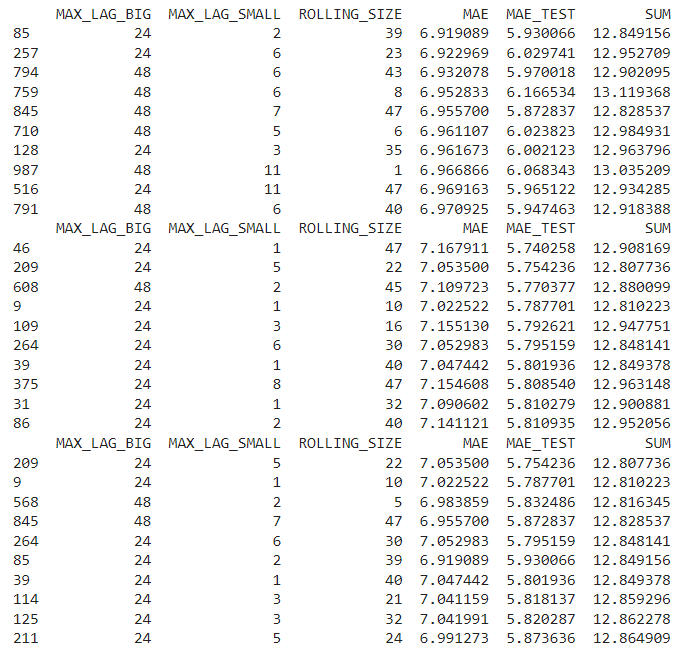

### Feature importance

Посмотрим на важность признаков

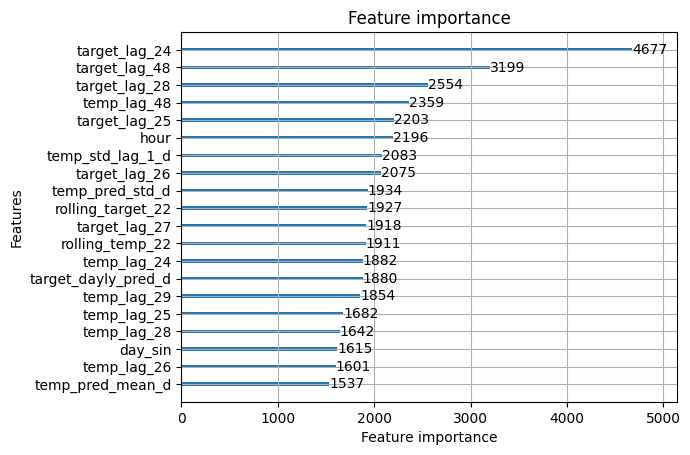

In [ ]:
lgb.plot_importance(grid_base.best_estimator_.named_steps['regressor'].booster_, max_num_features=20, importance_type='split')
plt.show()

Наиболее важными оказались признаки потребления электроэнергии за последние пару суток, признак времени (час) и стандартное отклонение температуры за предыдущие сутки.

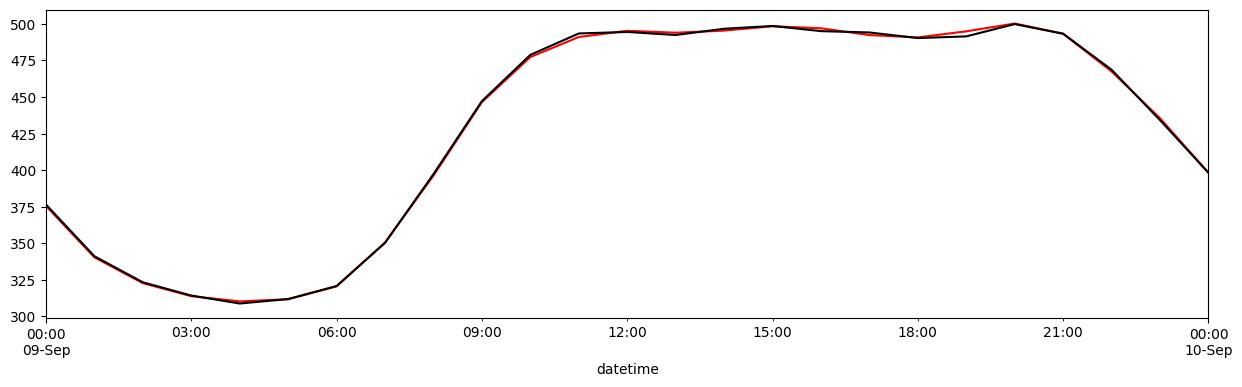

In [ ]:
# посмотрим как прогноз бьется с реальностью
plt.figure(figsize = (15, 4))
check.loc['2022-09-9':'2022-09-10', 'true'].plot(c='red')
pd.Series(check.loc['2022-09-9':'2022-09-10', 'preds'], index=y.index).plot(c='black')
plt.xlim('2022-09-9', '2022-09-10')
plt.show()

## Тестирование:

In [ ]:
test_daily = resampled_data_features(test)

test_daily_upd = pd.concat([train_daily[-9:], test_daily])
test_daily_upd = make_features_1d(test_daily_upd, 9, 2)
test_daily_upd = test_daily_upd.dropna()

X_1, y_1 = test_daily_upd.dropna().drop(columns=['target', 'weather_fact', 'weather_pred'], axis=1), test_daily_upd['target']

test_daily_upd.loc[:, 'target_dayly_pred'] = grid.predict(X_1)

new_features_test = test_daily_upd[daily_features]
new_features_test = new_features_test.rename(columns=dict(zip(daily_features, [i +'_d' for i in daily_features])))
new_features_test = new_features_test.resample('1H').ffill()

In [ ]:
test_resample_upd = pd.concat([train_resampled[-MAX_LAG_BIG-24:], test_resampled])
test_resample_upd = make_features(test_resample_upd,  MAX_LAG_BIG, MAX_LAG_SMALL, ROLLING_SIZE)
test_resample_upd_1 = pd.merge(test_resample_upd, new_features_test, how='left', on='datetime')
test_resample_upd_1.loc['2023-07'] = test_resample_upd_1.loc['2023-07'].ffill()
test_resample_upd_1 = test_resample_upd_1.dropna()


X_test, y_test = test_resample_upd_1.dropna().drop(columns=['target'], axis=1), test_resample_upd_1['target']

preds = grid_base.predict(X_test)

print('MAE TEST:', mean_absolute_error(y_test, preds))
print('MAPE TEST:', mean_absolute_percentage_error(y_test, preds))
print('R2 TEST:', r2_score(y_test, preds))

MAE TEST: 5.657223441700636
MAPE TEST: 0.01329591618728606
R2 TEST: 0.9884826161562416


## Выводы:

В ходе проекта была разработана модель для прогнозирования почасового энергопотребления в Калининградской области на основе исторических данных и ряда влияющих факторов. Модель LightGBM regressor с 2700 оценщиками продемонстрировала наилучшие результаты, значительно превосходя базовый метод прогнозирования, основанный на значениях предыдущего дня (MAE: 15.008).

## Ключевые результаты:

- **Высокая точность прогнозирования:** Модель достигла MAE 5.657 на тестовой выборке, что свидетельствует о её способности точно предсказывать почасовое энергопотребление.
  
- **Значительное улучшение:** По сравнению с базовым методом, модель LGBM regressor обеспечила улучшение MAE на 65.4%. Это подчеркивает эффективность выбранного подхода к моделированию и созданию признаков.
  
- **Важность лаговых признаков:** Наибольшее влияние на прогнозы оказывают лаговые значения целевой переменной (потребления энергии) за последние 24 и 48 часов. Это указывает на сильную автокорреляцию в данных и важность учета исторических паттернов потребления.
  
- **Влияние температуры:** Температурные факторы, такие как лаговые значения температуры, стандартное отклонение температуры и прогнозируемые значения температуры, также играют существенную роль в модели. Это подтверждает влияние погодных условий на энергопотребление, особенно в контексте отопления и кондиционирования помещений.
  
- **Ценность суточного прогноза:** Признак "target_dayly_pred", представляющий суточный прогноз энергопотребления, оказался одним из наиболее важных. Это демонстрирует, что учет долгосрочных трендов и суточных колебаний способствует повышению точности почасового прогноза.

## Вклад проекта:

Разработанная модель может быть использована для оптимизации управления энергопотреблением в Калининградской области. Точные прогнозы позволяют энергетическим компаниям более эффективно планировать производство и распределение электроэнергии, а также снижать издержки и повышать надежность энергоснабжения.

Методология проекта может быть применена для прогнозирования энергопотребления в других регионах или для других типов ресурсов. Гибкость модели и подхода к созданию признаков позволяет адаптировать их к различным задачам прогнозирования временных рядов.

Проект демонстрирует возможности современных методов машинного обучения для решения практических задач в энергетике. Использование LightGBM и других алгоритмов машинного обучения открывает новые перспективы для анализа данных и принятия обоснованных решений в энергетической отрасли.

## Дальнейшие шаги:

- **Интеграция с системами управления энергопотреблением:** Внедрение модели в существующие системы позволит автоматизировать процесс прогнозирования и использовать его результаты для принятия оперативных решений.
  
- **Разработка пользовательского интерфейса:** Создание удобного интерфейса для визуализации прогнозов и взаимодействия с моделью повысит её доступность и практическую ценность для пользователей.
  
- **Исследование дополнительных источников данных:** Включение данных о производстве электроэнергии, экономических показателях и региональных событиях может дополнительно повысить точность прогнозирования.
  
- **Анализ и интерпретация результатов модели:** Более глубокое понимание факторов, влияющих на энергопотребление, позволит разрабатывать эффективные стратегии управления спросом и энергоэффективности.

Проект демонстрирует успешное применение машинного обучения для решения актуальной задачи прогнозирования энергопотребления. Разработанная модель обладает высокой точностью и потенциалом для практического применения, что делает её ценным инструментом для энергетических компаний и региональных органов управления.
